In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

## Size distribution 
1. Subtract background contribution
2. Correct for completeness

In [74]:
from paper_figure import plot_size_distribution
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Total angular area [deg2]: 41.742812868496394


sample: 100%|███████████████████████████| 4000/4000 [00:04<00:00, 883.93it/s, 11 steps of size 1.93e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -1.83      0.30     -1.81     -2.27     -1.29    648.61      1.00
         b      1.91      0.12      1.90      1.71      2.09    677.99      1.00

Number of divergences: 0
Total angular area [deg2]: 34.0240549781722


Text(0.07303567465600133, 100, 'UPG: 1.5$\\sigma$')

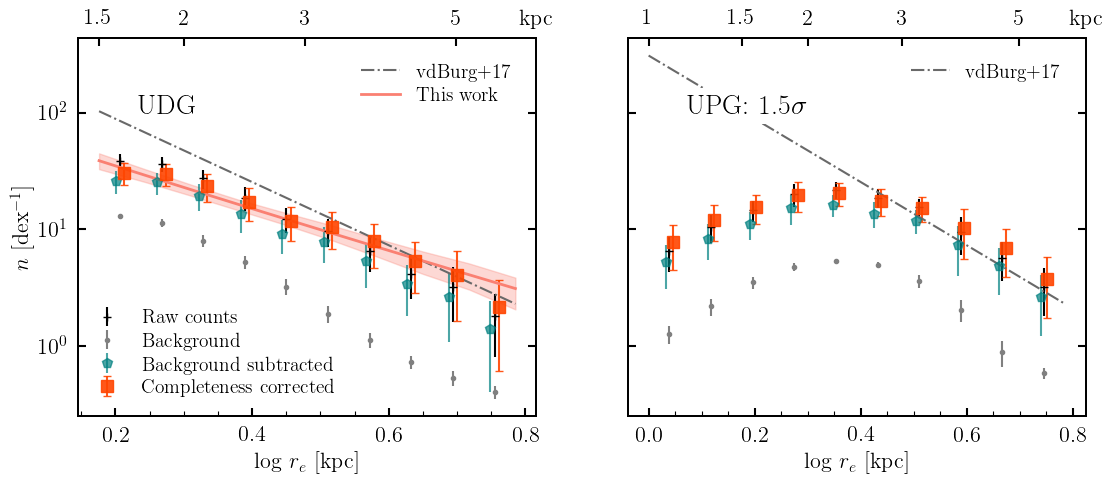

In [119]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220711.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax1 = plot_size_distribution(udg_cat, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UDG', ax=ax1, 
                                  fit_line=True, refit=True, verbose=True)
xlim = ax1.get_xlim()
plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 100, 'UDG', fontsize=20,
         bbox=dict(facecolor='w', alpha=1, edgecolor='none'))


### UPG ###
name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax2 = plot_size_distribution(udg_cat, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UPG', ax=ax2, fit_line=False,
                                  range_0=np.array([np.log10(1), np.log10(6.1)]), 
                                  dots_legend=False)
ax2.set_ylabel('')
xlim = ax2.get_xlim()
plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 100, r'UPG: 1.5$\sigma$', fontsize=20,
         bbox=dict(facecolor='w', alpha=1, edgecolor='none'))

In [37]:
from sample_cuts import moving_binned_statistic

In [38]:
n_bins = 10
n_slide = 20
range_0 = np.array([np.log10(1.5), np.log10(6.1)])

In [39]:
# R_e distribution of the real udg sample
output, cen = moving_binned_statistic(np.log10(udg_cat['rhalf_phys']), 
                                      np.log10(udg_cat['rhalf_phys']), 
                                      x_err=udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic='count', n_slide=n_slide)

n_cen = np.nanmean(output, axis=0) / (1) / total_area / np.diff(cen)[0]
n_std1 = np.sqrt(np.nanmean(output, axis=0)) / (1) / total_area / np.diff(cen)[0]
n_std2 = np.nanstd(output, axis=0) / (1) / total_area / np.diff(cen)[0]
n_std = np.sqrt(n_std1**2 + n_std2**2)

In [40]:
# R_e distribution of the fake udg sample: remove background
fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

output, cen = moving_binned_statistic(np.log10(fake_udg_cat['rhalf_phys']), 
                                      np.log10(fake_udg_cat['rhalf_phys']), 
                                      x_err=fake_udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic='count', n_slide=n_slide)
n_cen_bkg = np.nanmean(output, axis=0) / (10 * 20) / 24 / np.diff(cen)[0]
n_std_bkg1 = np.sqrt(np.nanmean(output, axis=0)) / (10 * 20) / 24 / np.diff(cen)[0]
n_std_bkg2 = np.nanstd(output, axis=0) / (10 * 20) / 24 / np.diff(cen)[0]
n_std_bkg = np.sqrt(n_std_bkg1**2 + n_std_bkg2**2)

In [42]:
# completeness in each size bin
output, cen = moving_binned_statistic(np.log10(udg_cat['rhalf_phys']), 
                                      udg_cat['completeness'], 
                                      x_err=udg_cat['rhalf_phys_err'],
                                      bins=n_bins, range_=range_0, 
                                      statistic=np.nanmean, 
                                      n_slide=n_slide)
comp_avg = np.nanmean(output, axis=0)
comp_std = np.nanstd(output, axis=0)

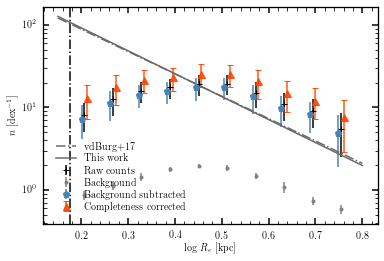

In [43]:
sct1 = plt.errorbar(cen, n_cen, yerr=n_std, 
             capsize=0,
             fmt='+', color='k', label='Raw counts')

sct2 = plt.errorbar(cen, n_cen_bkg, capsize=0,
             yerr=n_std_bkg, fmt='.', color='gray',
             markersize=6, label='Background')

sct3 = plt.errorbar(cen - 0.006, n_cen - n_cen_bkg, capsize=0,
             yerr=n_std, fmt='p', color='steelblue',
             markersize=7, label='Background subtracted')

sct4 = plt.errorbar(cen + 0.006, (n_cen - n_cen_bkg) / comp_avg, 
             yerr=np.sqrt(n_std**2 + n_std_bkg**2) / comp_avg, 
             fmt='^', color='orangered', alpha=0.9,
             markersize=7, label='Completeness corrected')

x0 = np.linspace(0.15, 0.8)
line1 = plt.plot(x0, 10**(-2.71 * x0 + 2.49), ls='-.', color='dimgray', label='vdBurg+17')
line2 = plt.plot(x0, 10**(-2.78 * x0 + 2.52), color='dimgray', label='This work')
plt.axvline(np.log10(1.5), ls='-.', color='k')

plt.xlabel(r'$\log\,R_e\ [\rm kpc]$')
plt.ylabel(r'$n\ [\rm dex^{-1}]$')

plt.legend()
plt.yscale('log')
# plt.ylim(0.1, 250)

(0.3, 250)

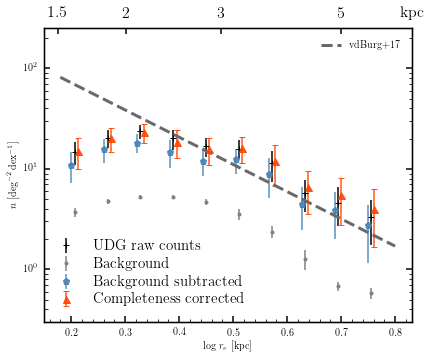

In [17]:
fig, ax = plt.subplots(figsize=(6.6, 5.4))

#  $n\propto R_e^{-2.78\pm0.25}$
# plt.axvline(np.log10(1.5), ls='-.', color='gray', zorder=0)

sct1 = plt.errorbar(cen, n_cen, yerr=n_std, 
             capsize=0,
             fmt='+', color='k', label='UDG raw counts')

sct2 = plt.errorbar(cen, n_cen_bkg, capsize=0,
             yerr=n_std_bkg, fmt='.', color='gray',
             markersize=6, label='Background')

sct3 = plt.errorbar(cen - 0.006, n_cen - n_cen_bkg, capsize=0,
             yerr=n_std, fmt='p', color='steelblue', alpha=0.9,
             markersize=7, label='Background subtracted')

sct4 = plt.errorbar(cen + 0.006, (n_cen - n_cen_bkg) / comp_avg, 
             yerr=np.sqrt(n_std**2 + n_std_bkg**2) / comp_avg, 
             fmt='^', color='orangered', alpha=0.9,
             markersize=7, label='Completeness corrected')

leg = plt.legend(loc=(0., 0.025), fontsize=15)
ax.add_artist(leg)

x0 = np.linspace(0.18, 0.8)
line1 = plt.plot(x0, 10**(-2.71 * x0 + 2.4), ls='--', lw=3, color='dimgray', label='vdBurg+17')
# line2 = plt.plot(x0, pred_mean, color='salmon', lw=2, label='This work')
# plt.fill_between(x0, pred_hpdi[0], pred_hpdi[1], alpha=0.3, color='salmon', interpolate=True)


plt.xlabel(r'$\log\,r_{e}\ [\rm kpc]$')
plt.ylabel(r'$n\ [\deg^{-2} \rm dex^{-1}]$')

plt.legend(handles=[line1[0]])

# Top banner
ax2 = ax.twiny() 
ax2.tick_params(direction='in')
lin_label = [1.5, 2, 3, 5, 7, 9]
lin_pos = [np.log10(i) for i in lin_label]
ax2.set_xticks(lin_pos)
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'kpc', fontsize=16)
ax2.xaxis.set_label_coords(1, 1.035)
ax2.tick_params(which='minor', top=False)

ax2.set_xticklabels([r'$\mathrm{'+str(i)+'}$' for i in lin_label], fontsize=16)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

plt.yscale('log')

plt.ylim(0.3, 250)

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/size_distribution.pdf', 
#             bbox_inches='tight', dpi=50)

---

## Spatial distribution

In [18]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto
from sample_cuts import moving_binned_statistic

In [19]:
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

In [20]:
udg_coord = SkyCoord(udg_cat['ra'], udg_cat['dec'], unit='deg')
host_coord = SkyCoord(udg_cat['host_RA'], udg_cat['host_DEC'], unit='deg')
dist = udg_coord.separation(host_coord)
dist_ratio = dist.to(u.deg).value / udg_cat['host_r_vir_ang'].data

In [21]:
n_bins = 13
n_slide = 10
range_0 = np.array([0.05, 1.0])
bins = np.histogram_bin_edges(dist_ratio, bins=n_bins, range=range_0)


fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220711.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg

---

In [22]:
unique_name, ind = np.unique(udg_cat['host_name'].data, return_index=True)

In [23]:
# completeness in each size bin
output, cen = moving_binned_statistic(dist_ratio, 
                                      udg_cat['completeness'], 
                                      x_err=None,
                                      bins=n_bins, range_=range_0, 
                                      statistic=np.nanmean, 
                                      n_slide=n_slide)
comp_avg = np.nanmean(output, axis=0)
comp_std = np.nanstd(output, axis=0)

In [24]:
# Method 1: bootstrap
result = {}
result['n_cen'] = []
result['n_std'] = []
result['n_cen_nobkg'] = []

for i in range(50):
    np.random.seed(i)
    _unique_name = np.random.choice(unique_name, size=200)
    n_cens = []
    n_stds_hist = []
    for name in _unique_name:
        output, cen = moving_binned_statistic(dist_ratio[udg_cat['host_name'] == name], 
                                              dist_ratio[udg_cat['host_name'] == name], 
                                              x_err=None,
                                              bins=n_bins, range_=range_0, 
                                              statistic='count', n_slide=n_slide)

        _n_cen = np.nanmean(output, axis=0) / (np.diff(np.pi * bins**2)) # number per annulus area [R_vir^2]
        _n_std = np.nanstd(output, axis=0) / (np.diff(np.pi * bins**2)) # error due to histogram
        n_cens.append(_n_cen)
        n_stds_hist.append(_n_std)
    
    contam_profile = density_bkg * np.diff(
        np.pi * (bins * udg_cat[udg_cat['host_name'] == name]['host_r_vir_ang'][:, None])**2
        ) / (np.diff(np.pi * bins**2))
    
    n_cen = np.average(n_cens - contam_profile[0], axis=0)
    n_std = np.sqrt(np.sum(np.array(n_stds_hist)**2, axis=0)) / len(n_stds_hist)
    
    result['n_cen'].append(n_cen)
    result['n_std'].append(n_std)
    result['n_cen_nobkg'].append(np.average(n_cens, axis=0))

In [25]:
n_cen = np.array(result['n_cen']).mean(axis=0)
n_std = np.sqrt(np.array(result['n_cen']).std(axis=0)**2 + np.mean(result['n_std'], axis=0)**2)

# completeness
n_corr = n_cen / comp_avg
n_corr_std = n_corr * np.sqrt((n_std / n_cen)**2 + (comp_std / comp_avg)**2)

<ErrorbarContainer object of 3 artists>

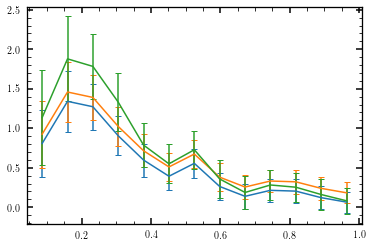

In [26]:
plt.errorbar(cen, n_cen, n_std)

plt.errorbar(cen, np.array(result['n_cen_nobkg']).mean(axis=0), n_std)

plt.errorbar(cen, n_corr, n_corr_std)

In [27]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto

cosmology.setCosmology('planck15')

flag = (cen > 0.2)
p_nfw = profile_nfw.NFWProfile(rhos=400, rs=0.1, z=0.0, mdef='vir')
res_nfw = p_nfw.fit(cen[flag], n_corr[flag], 
                 quantity='Sigma', 
                 q_err=n_std[flag-1]
                )

p_einasto = profile_einasto.EinastoProfile(M=10, alpha=0.3, c=1.83, z=0.0, mdef='vir')
res_ein = p_einasto.fit(cen[flag], n_corr[flag], 
                    q_err=n_corr_std[flag],
                    quantity='Sigma', 
                    method='leastsq')

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 8 steps. Best-fit parameters:
Parameter       rhos = 1.79e+01 [9.05e+00 .. 3.53e+01]
Parameter         rs = 1.93e-01 [1.44e-01 .. 2.58e-01]
chi2 / Ndof = 1.1 / 9 = 0.12
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 32 steps. Best-fit parameters:
Parameter       rhos = 3.13e+00 [3.65e-01 .. 2.68e+01]
Parameter         rs = 2.31e-01 [8.74e-02 .. 6.12e-01]
Parameter      alpha = 3.36e-01 [1.14e-01 .. 9.93e-01]
chi2 / Ndof = 1.9 / 8 = 0.23
-------------------------------------------------------------------------------------


In [28]:
nfw_conc = 1 / res_nfw['x'][1]
print(f'NFW conc = {nfw_conc:.3f} +', 1 / res_nfw['x_err'].T[1] - nfw_conc)

alpha = 1 / res_ein['x'][2]
print(f'alpha = {alpha:.3f} +', 1 / res_ein['x_err'].T[2] - alpha)

conc = 1 / res_ein['x'][1]
print(f'concentration = {conc:.3f} +', 1 / res_ein['x_err'].T[1] - conc)

NFW conc = 5.195 + [ 1.76597505 -1.31792265]
alpha = 2.976 + [ 5.82094787 -1.96906087]
concentration = 4.324 + [ 7.11710249 -2.68989329]


In [29]:
# np.save('./Catalog/nsa_z001_004/radial_prof.npy', np.vstack([cen, n_corr, n_corr_std]))

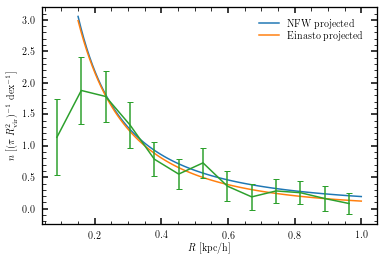

In [30]:
r = np.linspace(0.15, 1, 100)
sigma = p_nfw.surfaceDensity(r)
plt.plot(r, sigma, label='NFW projected')

sigma = p_einasto.surfaceDensity(r)
plt.plot(r, sigma, label='Einasto projected')

plt.errorbar(cen, n_corr, n_corr_std)

plt.xlabel(r'$R\ [\rm kpc/h]$')
plt.ylabel(r'$n\ [(\pi\ R_{\rm vir}^2)^{-1}\ \rm dex^{-1}]$')

plt.legend()

# plt.xscale('log')
# plt.yscale('log')

Text(0, 0.5, '$n\\ [(R_{\\rm vir})^{-2}]$')

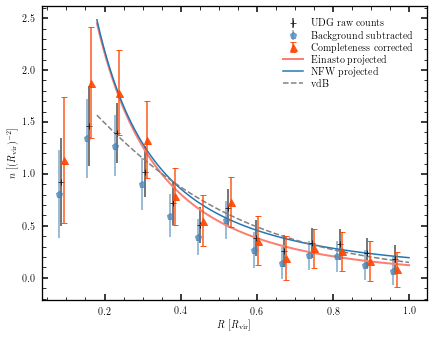

In [31]:
fig, ax = plt.subplots(figsize=(6.9, 5.4))

#  $n\propto R_e^{-2.78\pm0.25}$
# plt.axvline(np.log10(1.5), ls='-.', color='gray', zorder=0)

sct1 = plt.errorbar(cen, np.array(result['n_cen_nobkg']).mean(axis=0), yerr=n_std, 
             capsize=0, alpha=0.7,
             fmt='+', color='k', label='UDG raw counts')

sct3 = plt.errorbar(cen - 0.006, n_cen, 
                    capsize=0,
             yerr=n_std, fmt='p', color='steelblue', alpha=0.7,
             markersize=7, label='Background subtracted')

sct4 = plt.errorbar(cen + 0.006, n_corr, 
             yerr=n_corr_std, 
             fmt='^', color='orangered', alpha=0.9,
             markersize=7, label='Completeness corrected', zorder=10)

r = np.linspace(0.18, 1, 100)
sigma = p_einasto.surfaceDensity(r)
line1 = plt.plot(r, sigma, ls='-', color='salmon', lw=2, label='Einasto projected')

sigma = p_nfw.surfaceDensity(r)
line2 = plt.plot(r, sigma, color='C0', label='NFW projected')

p_ein_vdb = profile_einasto.EinastoProfile(rhos=0.5, alpha=0.92, rs=1/1.83, z=0.0, mdef='vir')
line3 = plt.plot(r, p_ein_vdb.surfaceDensity(r), color='gray', 
                 label='vdB', ls='--')

# plt.fill_between(x0, pred_hpdi[0], pred_hpdi[1], alpha=0.3, color='salmon', interpolate=True)

handles, labels = ax.get_legend_handles_labels()
order = [3, 4, 5, 0, 1, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


plt.xlabel(r'$R\ [R_{\rm vir}]$')
plt.ylabel(r'$n\ [(R_{\rm vir})^{-2}]$')

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/radial_distribution.pdf', 
#             bbox_inches='tight', dpi=50)

---